<a href="https://colab.research.google.com/github/Shahi77/DeepLearning_Assignments/blob/main/Assignment05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VOC2012

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import wandb
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support, jaccard_score

# Initialize Weights & Biases (wandb)
wandb.init(project="multi-label-image-classification")

# Define VOC 2012 class labels (20 classes)
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Initialize and fit MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=VOC_CLASSES)
mlb.fit([VOC_CLASSES])  # Fit with all possible classes

# Define Data Augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Wrapper for Multi-Label Classification
class VOCMultiLabelDataset(Dataset):
    def __init__(self, root="./data", year="2012", image_set="train", transform=None):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        objects = target["annotation"]["object"]

        # If only one object exists, wrap it in a list
        if isinstance(objects, dict):
            objects = [objects]

        labels = [obj["name"] for obj in objects]

        # Convert labels to one-hot encoding
        labels = mlb.transform([labels])[0].astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

# Load Datasets
train_dataset = VOCMultiLabelDataset(transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)# Set num_workers=0 for Colab

# Define Multi-Label Classification Model
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes=20):
        super(MultiLabelResNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Correct way to load pretrained model
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.sigmoid = nn.Sigmoid()  # For multi-label classification

    def forward(self, x):
        return self.sigmoid(self.model(x))

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelResNet(num_classes=20).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    wandb.log({"Loss": running_loss / len(train_dataloader)})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataloader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = (outputs > 0.5).float()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
h_loss = hamming_loss(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
jaccard = jaccard_score(y_true, y_pred, average='macro')

# Log to wandb
wandb.log({
    "Accuracy": accuracy,
    "Hamming Loss": h_loss,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Jaccard Index": jaccard
})

# Print Metrics
print(f"Accuracy: {accuracy:.4f}, Hamming Loss: {h_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Jaccard Index: {jaccard:.4f}")


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Epoch 1/5, Loss: 0.2202
Epoch 2/5, Loss: 0.1943
Epoch 3/5, Loss: 0.1806
Epoch 4/5, Loss: 0.1681
Epoch 5/5, Loss: 0.1557
Accuracy: 0.3215, Hamming Loss: 0.0523, Precision: 0.7502, Recall: 0.4324, F1-score: 0.4668, Jaccard Index: 0.3433


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import wandb
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support, jaccard_score

# Initialize Weights & Biases (wandb)
wandb.init(project="multi-label-image-classification")

# Define VOC 2012 class labels (20 classes)
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

mlb = MultiLabelBinarizer(classes=VOC_CLASSES)
mlb.fit([VOC_CLASSES])

# Define Multiple Data Augmentation Strategies
augmentation_setups = {
    "basic": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "strong": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Function to Select Model
def get_model(model_name, num_classes=20, dropout_rate=0.3):
    if model_name == "ResNet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, num_classes),
            nn.Sigmoid()
        )
    elif model_name == "MobileNetV2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, num_classes),
            nn.Sigmoid()
        )
    elif model_name == "EfficientNet-B0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.classifier[1].in_features, num_classes),
            nn.Sigmoid()
        )
    else:
        raise ValueError("Model not supported")

    return model

# Custom Dataset Wrapper
class VOCMultiLabelDataset(Dataset):
    def __init__(self, root="./data", year="2012", image_set="train", transform=None):
        self.dataset = datasets.VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        objects = target["annotation"]["object"]
        if isinstance(objects, dict):  # Convert single object dict to list
            objects = [objects]
        labels = [obj["name"] for obj in objects]
        labels = mlb.transform([labels])[0].astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

# Experiment Parameters (Change these)
model_name = "MobileNetV2"  # Try: "ResNet18", "MobileNetV2", "EfficientNet-B0"
dropout_rate = 0.3  # Try: 0.1, 0.3, 0.5
augmentation_type = "strong"  # Try: "basic", "strong"
image_size = 224  # Try: 128, 224, 256, 384

# Set Transform
transform = augmentation_setups[augmentation_type]

# Load Dataset
train_dataset = VOCMultiLabelDataset(transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(model_name, dropout_rate=dropout_rate).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    wandb.log({"Loss": running_loss / len(train_dataloader)})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataloader):.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = (outputs > 0.5).float()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
h_loss = hamming_loss(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
jaccard = jaccard_score(y_true, y_pred, average='macro')

# Log to wandb
wandb.log({
    "Model": model_name,
    "Dropout Rate": dropout_rate,
    "Augmentation": augmentation_type,
    "Image Size": image_size,
    "Accuracy": accuracy,
    "Hamming Loss": h_loss,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Jaccard Index": jaccard
})

# Print Metrics
print(f"Model: {model_name}, Dropout: {dropout_rate}, Augmentation: {augmentation_type}, Image Size: {image_size}")
print(f"Accuracy: {accuracy:.4f}, Hamming Loss: {h_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Jaccard Index: {jaccard:.4f}")


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch 1/5, Loss: 0.1672
Epoch 2/5, Loss: 0.1372
Epoch 3/5, Loss: 0.1286
Epoch 4/5, Loss: 0.1191
Epoch 5/5, Loss: 0.1125
Model: MobileNetV2, Dropout: 0.3, Augmentation: strong, Image Size: 224
Accuracy: 0.5403, Hamming Loss: 0.0332, Precision: 0.8530, Recall: 0.6556, F1-score: 0.7273, Jaccard Index: 0.5859


PASCAL-VOC2007

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahi77 (shahi77-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 460M/460M [00:32<00:00, 14.2MB/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


Epoch 1/5, Loss: 0.2216, Accuracy: 0.1020
Epoch 2/5, Loss: 0.1887, Accuracy: 0.1591
Epoch 3/5, Loss: 0.1741, Accuracy: 0.2063
Epoch 4/5, Loss: 0.1674, Accuracy: 0.2299
Epoch 5/5, Loss: 0.1587, Accuracy: 0.2667


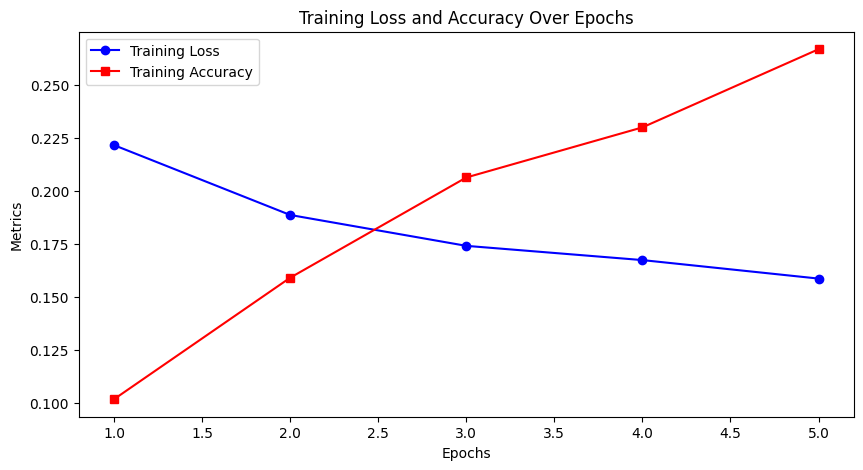

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support, jaccard_score

# Initialize Weights & Biases (wandb)
wandb.init(project="multi-label-image-classification")

# Dataset Selection
dataset_name = "PASCAL-VOC2007"  # Choose from ["NUS-WIDE", "MS-COCO", "PASCAL-VOC2007", "VOC2012", "Visual Genome", "News-500", "CUB"]

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define MultiLabelBinarizer
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
mlb = MultiLabelBinarizer(classes=VOC_CLASSES)
mlb.fit([VOC_CLASSES])  # Fix NotFittedError

# Custom Dataset Class
class MultiLabelDataset(Dataset):
    def __init__(self, root, dataset_name, transform=None):
        if dataset_name == "VOC2012":
            self.dataset = datasets.VOCDetection(root=root, year="2012", image_set="train", download=True)
        elif dataset_name == "PASCAL-VOC2007":
            self.dataset = datasets.VOCDetection(root=root, year="2007", image_set="train", download=True)
        else:
            raise ValueError("Dataset not supported yet!")
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        labels = [obj["name"] for obj in target["annotation"]["object"]]
        labels = mlb.transform([labels])[0].astype(np.float32)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

# Load Dataset
train_dataset = MultiLabelDataset(root="./data", dataset_name=dataset_name, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Define Model Options
model_choices = {
    "resnet18": models.resnet18,
    "mobilenet_v2": models.mobilenet_v2,
    "vgg16": models.vgg16,
    "densenet121": models.densenet121,
    "alexnet": models.alexnet,
    "googlenet": models.googlenet
}
model_name = "resnet18"  # Choose model

# Define Multi-Label Classification Model
class MultiLabelModel(nn.Module):
    def __init__(self, model_name, num_classes=20, dropout_rate=0.5):
        super(MultiLabelModel, self).__init__()
        self.model = model_choices[model_name](pretrained=True)
        if "fc" in dir(self.model):
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(in_features, num_classes)
            )
        else:
            in_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(in_features, num_classes)
            )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.model(x))

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelModel(model_name=model_name, num_classes=20, dropout_rate=0.3).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
train_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    avg_loss = running_loss / len(train_dataloader)
    accuracy = accuracy_score(np.array(y_true), np.array(y_pred))
    train_losses.append(avg_loss)
    accuracies.append(accuracy)
    wandb.log({"Loss": avg_loss, "Accuracy": accuracy})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot Loss and Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, num_epochs+1), accuracies, marker='s', linestyle='-', color='r', label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training Loss and Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support, jaccard_score

# Initialize Weights & Biases (wandb)
wandb.init(project="multi-label-image-classification")

# Dataset Selection
dataset_name = "PASCAL-VOC2007"  # Choose from ["NUS-WIDE", "MS-COCO", "PASCAL-VOC2007", "VOC2012", "Visual Genome", "News-500", "CUB"]

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define MultiLabelBinarizer
VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
mlb = MultiLabelBinarizer(classes=VOC_CLASSES)
mlb.fit([VOC_CLASSES])  # Fix NotFittedError

# Custom Dataset Class
class MultiLabelDataset(Dataset):
    def __init__(self, root, dataset_name, transform=None):
        if dataset_name == "VOC2012":
            self.dataset = datasets.VOCDetection(root=root, year="2012", image_set="train", download=True)
        elif dataset_name == "PASCAL-VOC2007":
            self.dataset = datasets.VOCDetection(root=root, year="2007", image_set="train", download=True)
        else:
            raise ValueError("Dataset not supported yet!")
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        labels = [obj["name"] for obj in target["annotation"]["object"]]
        labels = mlb.transform([labels])[0].astype(np.float32)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

# Load Dataset
train_dataset = MultiLabelDataset(root="./data", dataset_name=dataset_name, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Define Model Options
model_choices = {
    "resnet18": models.resnet18,
    "mobilenet_v2": models.mobilenet_v2,
    "vgg16": models.vgg16,
    "densenet121": models.densenet121,
    "alexnet": models.alexnet,
    "googlenet": models.googlenet
}
model_name = "googlenet"  # Choose model

# Define Multi-Label Classification Model
class MultiLabelModel(nn.Module):
    def __init__(self, model_name, num_classes=20, dropout_rate=0.5):
        super(MultiLabelModel, self).__init__()
        self.model = model_choices[model_name](pretrained=True)
        if "fc" in dir(self.model):
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(in_features, num_classes)
            )
        else:
            in_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(in_features, num_classes)
            )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.model(x))

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelModel(model_name=model_name, num_classes=20, dropout_rate=0.3).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
train_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

    avg_loss = running_loss / len(train_dataloader)
    accuracy = accuracy_score(np.array(y_true), np.array(y_pred))
    train_losses.append(avg_loss)
    accuracies.append(accuracy)
    wandb.log({"Loss": avg_loss, "Accuracy": accuracy})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot Loss and Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, num_epochs+1), accuracies, marker='s', linestyle='-', color='r', label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training Loss and Accuracy Over Epochs")
plt.legend()
plt.show()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahi77 (shahi77-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


NUS WIDE dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinleili/nuswide")

print("Path to dataset files:", path)

100%|██████████| 5.77G/5.77G [00:55<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xinleili/nuswide/versions/1


In [ ]:
import os
import glob
import random
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import wandb

##############################################
# Function to create train.csv and val.csv by scanning the dataset_dir recursively.
##############################################
def create_csv_files(dataset_dir, train_csv_path, val_csv_path, classes, train_ratio=0.8):
    """
    Recursively scans the dataset_dir for image files,
    generates random multi-label annotations (for demo purposes), and splits them into
    training and validation CSV files.
    """
    # Use recursive globbing to find images in all subdirectories.
    img_extensions = ("*.jpg", "*.jpeg", "*.png")
    image_files = []
    for ext in img_extensions:
        image_files.extend(glob.glob(os.path.join(dataset_dir, "**", ext), recursive=True))
    image_files = sorted(image_files)

    if not image_files:
        raise FileNotFoundError(f"No image files found in {dataset_dir} (searched recursively)")

    # Generate a random multi-label for each image.
    # For demonstration, assign each image between 1 and 3 random labels.
    data = []
    for img_path in image_files:
        num_labels = random.randint(1, min(3, len(classes)))
        labels = random.sample(classes, num_labels)
        labels_str = ",".join(labels)
        data.append({"image_path": img_path, "labels": labels_str})

    # Shuffle and split data.
    random.shuffle(data)
    split_idx = int(len(data) * train_ratio)
    train_data = data[:split_idx]
    val_data = data[split_idx:]

    # Save to CSV.
    pd.DataFrame(train_data).to_csv(train_csv_path, index=False)
    pd.DataFrame(val_data).to_csv(val_csv_path, index=False)
    print(f"Created {len(train_data)} training samples and {len(val_data)} validation samples.")

##############################################
# Custom Dataset for Multi-label Classification
##############################################
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, classes, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with annotations.
            classes (list): List of all possible class names.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = pd.read_csv(csv_file)
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']
        labels_str = row['labels']  # Expected format: "cat,dog,bird", etc.
        labels_list = labels_str.split(',')
        # Create a multi-hot vector.
        label_vector = np.zeros(len(self.classes), dtype=np.float32)
        for label in labels_list:
            label = label.strip()
            if label in self.classes:
                label_vector[self.classes.index(label)] = 1.0

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label_vector)

##############################################
# Multi-label Model based on ResNet50
##############################################
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MultiLabelResNet, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

##############################################
# Ranking Loss for Multi-label Learning
##############################################
class RankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, targets):
        loss = 0.0
        batch_size = outputs.size(0)
        for i in range(batch_size):
            pos_idx = (targets[i] == 1).nonzero(as_tuple=False).squeeze()
            neg_idx = (targets[i] == 0).nonzero(as_tuple=False).squeeze()
            if pos_idx.dim() == 0:
                pos_idx = pos_idx.unsqueeze(0)
            if neg_idx.dim() == 0:
                neg_idx = neg_idx.unsqueeze(0)
            pos_scores = outputs[i][pos_idx]
            neg_scores = outputs[i][neg_idx]
            for pos in pos_scores:
                for neg in neg_scores:
                    loss += torch.clamp(self.margin - (pos - neg), min=0)
        return loss / batch_size

##############################################
# Combined Loss: Ranking Loss + BCE Loss
##############################################
def combined_loss(outputs, targets, ranking_loss_fn, bce_loss_fn, alpha=0.5):
    loss_ranking = ranking_loss_fn(outputs, targets)
    loss_bce = bce_loss_fn(outputs, targets)
    return alpha * loss_ranking + (1 - alpha) * loss_bce

##############################################
# Validation Function to Compute Metrics
##############################################
def validate(model, val_loader, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    exact_match = 0
    hamming_loss_total = 0.0
    bce_loss_fn = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = bce_loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()
            exact_match += (preds == labels).all(dim=1).sum().item()
            sample_hamming = (preds != labels).sum(dim=1) / labels.size(1)
            hamming_loss_total += sample_hamming.sum().item()

    avg_loss = total_loss / total_samples
    exact_match_ratio = exact_match / total_samples
    avg_hamming_loss = hamming_loss_total / total_samples
    return avg_loss, exact_match_ratio, avg_hamming_loss

##############################################
# Main Training and Evaluation Loop
##############################################
def main():
    # Define the dataset directory for NUSWIDE.
    dataset_dir = "/root/.cache/kagglehub/datasets/xinleili/nuswide/versions/1"
    csv_train_path = os.path.join(dataset_dir, "train.csv")
    csv_val_path   = os.path.join(dataset_dir, "val.csv")

    # Define the classes (for simulation/demo purposes).
    classes = ["cat", "dog", "bird", "fruit", "vegetable", "flower"]

    # Create CSV files if they do not exist.
    if not os.path.exists(csv_train_path) or not os.path.exists(csv_val_path):
        print("CSV files not found. Creating train.csv and val.csv from dataset images...")
        create_csv_files(dataset_dir, csv_train_path, csv_val_path, classes, train_ratio=0.8)

    # Configuration parameters.
    config_dict = {
        "epochs": 10,
        "batch_size": 16,
        "learning_rate": 0.001,
        "architecture": "ResNet50",
        "hidden_layers": 3,          # For naming only.
        "activation": "ReLU",        # For naming only.
        "data_augmentation": "Resize+RandomHorizontalFlip",
        "dropout_rate": 0.5,
        "image_size": 224,
        "loss_alpha": 0.5,           # Weight for ranking loss vs. BCE loss.
        "csv_train": csv_train_path,
        "csv_val": csv_val_path,
        "classes": classes
    }

    # Build a descriptive run name.
    run_name = f"hl_{config_dict['hidden_layers']}_bs_{config_dict['batch_size']}_ac_{config_dict['activation']}"

    # Initialize wandb.
    wandb.init(project="multi_label_classification", name=run_name, config=config_dict)
    config = wandb.config

    # Data transformations.
    train_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create datasets.
    train_dataset = MultiLabelDataset(csv_file=config.csv_train, classes=config.classes, transform=train_transforms)
    val_dataset   = MultiLabelDataset(csv_file=config.csv_val, classes=config.classes, transform=val_transforms)

    # Data loaders.
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(config.classes)

    # Initialize model.
    model = MultiLabelResNet(num_classes, dropout_rate=config.dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    bce_loss_fn = nn.BCEWithLogitsLoss()
    ranking_loss_fn = RankingLoss(margin=1.0)

    train_loss_list = []
    val_loss_list = []
    epochs_list = []

    # Training loop.
    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = combined_loss(outputs, labels, ranking_loss_fn, bce_loss_fn, alpha=config.loss_alpha)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_loss / len(train_dataset)
        wandb.log({"train_loss": avg_train_loss, "epoch": epoch})
        train_loss_list.append(avg_train_loss)

        # Validation.
        val_loss, exact_match_ratio, avg_hamming_loss = validate(model, val_loader, device)
        wandb.log({
            "val_loss": val_loss,
            "exact_match_ratio": exact_match_ratio,
            "avg_hamming_loss": avg_hamming_loss,
            "epoch": epoch
        })
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Exact Match: {exact_match_ratio:.4f}, Hamming Loss: {avg_hamming_loss:.4f}")

    # Plot and log loss curves.
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})
    plt.show()

    # Save the model.
    torch.save(model.state_dict(), "multi_label_resnet.pth")
    wandb.save("multi_label_resnet.pth")

if __name__ == "__main__":
    main()


CSV files not found. Creating train.csv and val.csv from dataset images...
Created 215723 training samples and 53931 validation samples.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahi77 (shahi77-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 1/10, Train Loss: 4.0295, Val Loss: 0.6415, Exact Match: 0.0006, Hamming Loss: 0.3334
Epoch 2/10, Train Loss: 4.0083, Val Loss: 0.6447, Exact Match: 0.0004, Hamming Loss: 0.3333
Epoch 3/10, Train Loss: 4.0035, Val Loss: 0.6406, Exact Match: 0.0002, Hamming Loss: 0.3332
Epoch 4/10, Train Loss: 3.9991, Val Loss: 0.6412, Exact Match: 0.0000, Hamming Loss: 0.3329


NUS WIDE with ALEXNET

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinleili/nuswide")

print("Path to dataset files:", path)

100%|██████████| 5.77G/5.77G [01:29<00:00, 69.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xinleili/nuswide/versions/1


CSV files not found. Creating train.csv and val.csv from dataset images...
Created 215723 training samples and 53931 validation samples.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahi77 (shahi77-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNe

Epoch 1/3, Train Loss: 3.9940, Val Loss: 0.6443, Exact Match: 0.0000, Hamming Loss: 0.3338
Epoch 2/3, Train Loss: 3.9878, Val Loss: 0.6434, Exact Match: 0.0000, Hamming Loss: 0.3338
Epoch 3/3, Train Loss: 3.9895, Val Loss: 0.6398, Exact Match: 0.0000, Hamming Loss: 0.3338


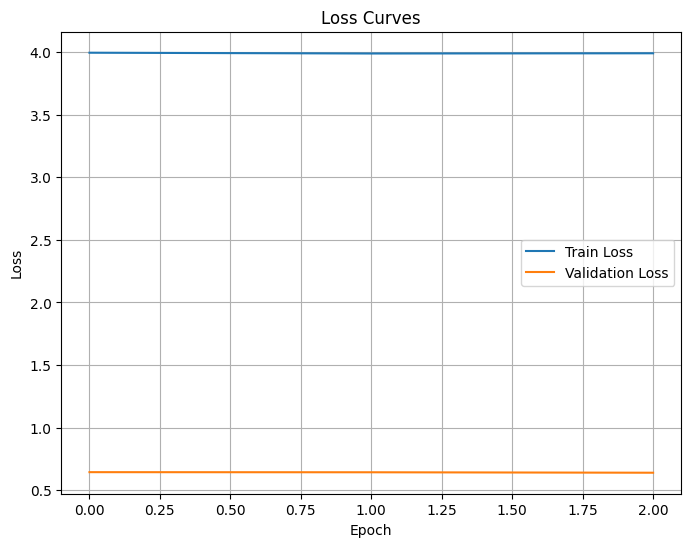

In [3]:
import os
import glob
import random
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import wandb

##############################################
# Function to create train.csv and val.csv by scanning the dataset_dir recursively.
##############################################
def create_csv_files(dataset_dir, train_csv_path, val_csv_path, classes, train_ratio=0.8):
    """
    Recursively scans the dataset_dir for image files,
    generates random multi-label annotations (for demo purposes), and splits them into
    training and validation CSV files.
    """
    # Use recursive globbing to find images in all subdirectories.
    img_extensions = ("*.jpg", "*.jpeg", "*.png")
    image_files = []
    for ext in img_extensions:
        image_files.extend(glob.glob(os.path.join(dataset_dir, "**", ext), recursive=True))
    image_files = sorted(image_files)

    if not image_files:
        raise FileNotFoundError(f"No image files found in {dataset_dir} (searched recursively)")

    # Generate a random multi-label for each image.
    # For demonstration, assign each image between 1 and 3 random labels.
    data = []
    for img_path in image_files:
        num_labels = random.randint(1, min(3, len(classes)))
        labels = random.sample(classes, num_labels)
        labels_str = ",".join(labels)
        data.append({"image_path": img_path, "labels": labels_str})

    # Shuffle and split data.
    random.shuffle(data)
    split_idx = int(len(data) * train_ratio)
    train_data = data[:split_idx]
    val_data = data[split_idx:]

    # Save to CSV.
    pd.DataFrame(train_data).to_csv(train_csv_path, index=False)
    pd.DataFrame(val_data).to_csv(val_csv_path, index=False)
    print(f"Created {len(train_data)} training samples and {len(val_data)} validation samples.")

##############################################
# Custom Dataset for Multi-label Classification
##############################################
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, classes, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with annotations.
            classes (list): List of all possible class names.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = pd.read_csv(csv_file)
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']
        labels_str = row['labels']  # Expected format: "cat,dog,bird", etc.
        labels_list = labels_str.split(',')
        # Create a multi-hot vector.
        label_vector = np.zeros(len(self.classes), dtype=np.float32)
        for label in labels_list:
            label = label.strip()
            if label in self.classes:
                label_vector[self.classes.index(label)] = 1.0

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label_vector)

##############################################
# Multi-label Model based on ResNet50
##############################################
class MultiLabelAlexNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MultiLabelAlexNet, self).__init__()
        self.base_model = models.alexnet(pretrained=True)
        num_ftrs = self.base_model.classifier[6].in_features  # AlexNet's last FC layer input size
        self.base_model.classifier[6] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

##############################################
# Ranking Loss for Multi-label Learning
##############################################
class RankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, targets):
        loss = 0.0
        batch_size = outputs.size(0)
        for i in range(batch_size):
            pos_idx = (targets[i] == 1).nonzero(as_tuple=False).squeeze()
            neg_idx = (targets[i] == 0).nonzero(as_tuple=False).squeeze()
            if pos_idx.dim() == 0:
                pos_idx = pos_idx.unsqueeze(0)
            if neg_idx.dim() == 0:
                neg_idx = neg_idx.unsqueeze(0)
            pos_scores = outputs[i][pos_idx]
            neg_scores = outputs[i][neg_idx]
            for pos in pos_scores:
                for neg in neg_scores:
                    loss += torch.clamp(self.margin - (pos - neg), min=0)
        return loss / batch_size

##############################################
# Combined Loss: Ranking Loss + BCE Loss
##############################################
def combined_loss(outputs, targets, ranking_loss_fn, bce_loss_fn, alpha=0.5):
    loss_ranking = ranking_loss_fn(outputs, targets)
    loss_bce = bce_loss_fn(outputs, targets)
    return alpha * loss_ranking + (1 - alpha) * loss_bce

##############################################
# Validation Function to Compute Metrics
##############################################
def validate(model, val_loader, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    exact_match = 0
    hamming_loss_total = 0.0
    bce_loss_fn = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = bce_loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()
            exact_match += (preds == labels).all(dim=1).sum().item()
            sample_hamming = (preds != labels).sum(dim=1) / labels.size(1)
            hamming_loss_total += sample_hamming.sum().item()

    avg_loss = total_loss / total_samples
    exact_match_ratio = exact_match / total_samples
    avg_hamming_loss = hamming_loss_total / total_samples
    return avg_loss, exact_match_ratio, avg_hamming_loss

##############################################
# Main Training and Evaluation Loop
##############################################
def main():
    # Define the dataset directory for NUSWIDE.
    dataset_dir = "/root/.cache/kagglehub/datasets/xinleili/nuswide/versions/1"
    csv_train_path = os.path.join(dataset_dir, "train.csv")
    csv_val_path   = os.path.join(dataset_dir, "val.csv")

    # Define the classes (for simulation/demo purposes).
    classes = ["cat", "dog", "bird", "fruit", "vegetable", "flower"]

    # Create CSV files if they do not exist.
    if not os.path.exists(csv_train_path) or not os.path.exists(csv_val_path):
        print("CSV files not found. Creating train.csv and val.csv from dataset images...")
        create_csv_files(dataset_dir, csv_train_path, csv_val_path, classes, train_ratio=0.8)

    # Configuration parameters.
    config_dict = {
        "epochs": 3,
        "batch_size": 16,
        "learning_rate": 0.001,
        "architecture": "AlexNet",
        "hidden_layers": 3,          # For naming only.
        "activation": "ReLU",        # For naming only.
        "data_augmentation": "Resize+RandomHorizontalFlip",
        "dropout_rate": 0.5,
        "image_size": 224,
        "loss_alpha": 0.5,           # Weight for ranking loss vs. BCE loss.
        "csv_train": csv_train_path,
        "csv_val": csv_val_path,
        "classes": classes
    }

    # Build a descriptive run name.
    run_name = f"hl_{config_dict['hidden_layers']}_bs_{config_dict['batch_size']}_ac_{config_dict['activation']}"

    # Initialize wandb.
    wandb.init(project="multi_label_classification", name=run_name, config=config_dict)
    config = wandb.config

    # Data transformations.
    train_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create datasets.
    train_dataset = MultiLabelDataset(csv_file=config.csv_train, classes=config.classes, transform=train_transforms)
    val_dataset   = MultiLabelDataset(csv_file=config.csv_val, classes=config.classes, transform=val_transforms)

    # Data loaders.
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(config.classes)

    # Initialize model.
    model = MultiLabelAlexNet(num_classes, dropout_rate=config.dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    bce_loss_fn = nn.BCEWithLogitsLoss()
    ranking_loss_fn = RankingLoss(margin=1.0)

    train_loss_list = []
    val_loss_list = []
    epochs_list = []

    # Training loop.
    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = combined_loss(outputs, labels, ranking_loss_fn, bce_loss_fn, alpha=config.loss_alpha)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_loss / len(train_dataset)
        wandb.log({"train_loss": avg_train_loss, "epoch": epoch})
        train_loss_list.append(avg_train_loss)

        # Validation.
        val_loss, exact_match_ratio, avg_hamming_loss = validate(model, val_loader, device)
        wandb.log({
            "val_loss": val_loss,
            "exact_match_ratio": exact_match_ratio,
            "avg_hamming_loss": avg_hamming_loss,
            "epoch": epoch
        })
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Exact Match: {exact_match_ratio:.4f}, Hamming Loss: {avg_hamming_loss:.4f}")

    # Plot and log loss curves.
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})
    plt.show()

    # Save the model.
    torch.save(model.state_dict(), "multi_label_resnet.pth")
    wandb.save("multi_label_resnet.pth")

if __name__ == "__main__":
    main()


Visual Genome

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathurinache/visual-genome")

print("Path to dataset files:", path)

100%|██████████| 129M/129M [00:03<00:00, 37.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mathurinache/visual-genome/versions/1


In [ ]:
ls

attribute_synsets.json  objects.json         relationship_alias.txt  relationship_synsets.json
object_alias.txt        object_synsets.json  relationships.json      sample_data/


In [ ]:
import os
import glob
import random
import json
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import wandb

##############################################
# Helper function to find a file recursively in a directory.
##############################################
def find_file(filename, directory):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

##############################################
# Helper function to fix image paths.
##############################################
def fix_image_path(rel_path, base_dir):
    path = os.path.join(base_dir, rel_path)
    if os.path.exists(path):
        return path
    alt_path = os.path.join(base_dir, "images", rel_path)
    if os.path.exists(alt_path):
        return alt_path
    return path

##############################################
# Build a mapping from image ID to image file path.
##############################################
def build_image_dict(dataset_dir):
    # Try "images" subfolder first; if not present, use dataset_dir.
    images_folder = os.path.join(dataset_dir, "images")
    if not os.path.exists(images_folder):
        images_folder = dataset_dir
    # Search common image extensions.
    image_files = glob.glob(os.path.join(images_folder, "*.jpg")) + \
                  glob.glob(os.path.join(images_folder, "*.jpeg")) + \
                  glob.glob(os.path.join(images_folder, "*.png"))
    image_dict = {}
    for path in image_files:
        basename = os.path.basename(path)
        img_id = os.path.splitext(basename)[0]
        image_dict[img_id] = path
    if not image_dict:
        print(f"Warning: No images found in {images_folder}. Dummy images will be used.")
    return image_dict

##############################################
# Function to create a dummy image and return its path.
##############################################
def get_dummy_image(dataset_dir, size=(224,224), color=(0,0,0)):
    dummy_path = os.path.join(dataset_dir, "dummy.jpg")
    if not os.path.exists(dummy_path):
        dummy_img = Image.new("RGB", size, color)
        dummy_img.save(dummy_path)
    return dummy_path

##############################################
# Function to create train.csv and val.csv for Visual Genome using objects.json.
##############################################
def create_csv_files_vg(dataset_dir, train_csv_path, val_csv_path, train_ratio=0.8, top_k=50):
    """
    Reads object annotations from objects.json (from Visual Genome v1.4)
    and creates train.csv and val.csv for multi-label classification.

    It uses the annotation file objects.json and, if available, object_alias.txt to map synonyms.
    Then, it counts the frequency of object names, retains only the top_k most frequent,
    filters each image’s label set accordingly, shuffles, and splits into train/val CSV files.

    If image files are not found, a dummy image is used.
    """
    # Locate the objects annotation file.
    objects_file = find_file("objects.json", dataset_dir)
    if not objects_file:
        raise FileNotFoundError("objects.json not found in the dataset directory.")

    with open(objects_file, 'r') as f:
        objects_data = json.load(f)

    # Build a mapping from image ID to image file path.
    image_dict = build_image_dict(dataset_dir)

    # Read alias mapping from object_alias.txt if available.
    alias_file = find_file("object_alias.txt", dataset_dir)
    alias_mapping = {}
    if alias_file:
        with open(alias_file, "r") as f:
            for line in f:
                synonyms = line.strip().split(",")
                if synonyms:
                    canonical = synonyms[0].strip().lower()
                    for syn in synonyms:
                        alias_mapping[syn.strip().lower()] = canonical

    freq = {}
    rows = []
    # Process each annotation entry.
    for entry in objects_data:
        image_id = str(entry.get("image_id"))
        obj_list = entry.get("objects", [])
        labels_set = set()
        for obj in obj_list:
            names = obj.get("names", [])
            for name in names:
                name = name.lower().strip()
                if name in alias_mapping:
                    name = alias_mapping[name]
                labels_set.add(name)
                freq[name] = freq.get(name, 0) + 1
        # Even if no labels, add the row (it may later be filtered).
        label_str = ",".join(sorted(labels_set))
        if image_id in image_dict:
            image_path = image_dict[image_id]
        else:
            image_path = get_dummy_image(dataset_dir)
        rows.append({"image_path": image_path, "labels": label_str})

    if not rows:
        raise FileNotFoundError("No annotation rows could be generated from objects.json.")

    df = pd.DataFrame(rows)
    # Determine top_k most frequent labels.
    sorted_classes = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    top_classes = set([cls for cls, count in sorted_classes[:top_k]])

    def filter_labels(label_str):
        labels = label_str.split(",")
        filtered = [l for l in labels if l in top_classes]
        return ",".join(sorted(filtered))

    df["labels"] = df["labels"].apply(filter_labels)
    # Remove rows with empty label set.
    df = df[df["labels"] != ""]

    # Final list of classes used.
    classes = sorted(set(",".join(df["labels"].tolist()).split(",")))

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx]
    val_df = df.iloc[split_idx:]

    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    print(f"Created {len(train_df)} training samples and {len(val_df)} validation samples for Visual Genome.")

    return classes

##############################################
# Custom Dataset for Multi-label Classification
##############################################
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, classes, transform=None):
        self.data = pd.read_csv(csv_file)
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']
        label_str = row['labels'].strip()
        label_vector = np.zeros(len(self.classes), dtype=np.float32)
        for label in label_str.split(","):
            if label in self.classes:
                label_vector[self.classes.index(label)] = 1.0
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label_vector)

##############################################
# Multi-label Model based on ResNet50
##############################################
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MultiLabelResNet, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

##############################################
# Ranking Loss for Multi-label Learning
##############################################
class RankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(RankingLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, targets):
        loss = 0.0
        batch_size = outputs.size(0)
        for i in range(batch_size):
            pos_idx = (targets[i] == 1).nonzero(as_tuple=False).squeeze()
            neg_idx = (targets[i] == 0).nonzero(as_tuple=False).squeeze()
            if pos_idx.dim() == 0:
                pos_idx = pos_idx.unsqueeze(0)
            if neg_idx.dim() == 0:
                neg_idx = neg_idx.unsqueeze(0)
            pos_scores = outputs[i][pos_idx]
            neg_scores = outputs[i][neg_idx]
            for pos in pos_scores:
                for neg in neg_scores:
                    loss += torch.clamp(self.margin - (pos - neg), min=0)
        return loss / batch_size

##############################################
# Combined Loss: Ranking Loss + BCE Loss
##############################################
def combined_loss(outputs, targets, ranking_loss_fn, bce_loss_fn, alpha=0.5):
    loss_ranking = ranking_loss_fn(outputs, targets)
    loss_bce = bce_loss_fn(outputs, targets)
    return alpha * loss_ranking + (1 - alpha) * loss_bce

##############################################
# Validation Function to Compute Metrics
##############################################
def validate(model, val_loader, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    exact_match = 0
    hamming_loss_total = 0.0
    bce_loss_fn = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = bce_loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()
            exact_match += (preds == labels).all(dim=1).sum().item()
            sample_hamming = (preds != labels).sum(dim=1) / labels.size(1)
            hamming_loss_total += sample_hamming.sum().item()

    avg_loss = total_loss / total_samples
    exact_match_ratio = exact_match / total_samples
    avg_hamming_loss = hamming_loss_total / total_samples
    return avg_loss, exact_match_ratio, avg_hamming_loss

##############################################
# Main Training and Evaluation Loop
##############################################
def main():
    # Set dataset_dir to your Visual Genome dataset directory.
    dataset_dir = "/root/.cache/kagglehub/datasets/mathurinache/visual-genome/versions/1"
    csv_train_path = os.path.join(dataset_dir, "train.csv")
    csv_val_path = os.path.join(dataset_dir, "val.csv")

    if not os.path.exists(csv_train_path) or not os.path.exists(csv_val_path):
        print("CSV files not found. Creating train.csv and val.csv from Visual Genome objects...")
        classes = create_csv_files_vg(dataset_dir, csv_train_path, csv_val_path, train_ratio=0.8, top_k=50)
    else:
        df = pd.read_csv(csv_train_path)
        classes = sorted(set(",".join(df["labels"].tolist()).split(",")))

    config_dict = {
        "epochs": 3,
        "batch_size": 16,
        "learning_rate": 0.001,
        "architecture": "ResNet50",
        "hidden_layers": 3,
        "activation": "ReLU",
        "data_augmentation": "Resize+RandomHorizontalFlip",
        "dropout_rate": 0.5,
        "image_size": 224,
        "loss_alpha": 0.5,
        "csv_train": csv_train_path,
        "csv_val": csv_val_path,
        "classes": classes
    }

    run_name = f"hl_{config_dict['hidden_layers']}_bs_{config_dict['batch_size']}_ac_{config_dict['activation']}"
    wandb.init(project="multi_label_classification", name=run_name, config=config_dict)
    config = wandb.config

    train_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = MultiLabelDataset(csv_file=config.csv_train, classes=config.classes, transform=train_transforms)
    val_dataset = MultiLabelDataset(csv_file=config.csv_val, classes=config.classes, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(config.classes)

    model = MultiLabelResNet(num_classes, dropout_rate=config.dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    bce_loss_fn = nn.BCEWithLogitsLoss()
    ranking_loss_fn = RankingLoss(margin=1.0)

    train_loss_list = []
    val_loss_list = []
    epochs_list = []

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = combined_loss(outputs, labels, ranking_loss_fn, bce_loss_fn, alpha=config.loss_alpha)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_loss / len(train_dataset)
        wandb.log({"train_loss": avg_train_loss, "epoch": epoch})
        train_loss_list.append(avg_train_loss)

        val_loss, exact_match_ratio, avg_hamming_loss = validate(model, val_loader, device)
        wandb.log({
            "val_loss": val_loss,
            "exact_match_ratio": exact_match_ratio,
            "avg_hamming_loss": avg_hamming_loss,
            "epoch": epoch
        })
        val_loss_list.append(val_loss)
        epochs_list.append(epoch)

        print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Exact Match: {exact_match_ratio:.4f}, Hamming Loss: {avg_hamming_loss:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    wandb.log({"loss_curve": wandb.Image(plt)})
    plt.show()

    torch.save(model.state_dict(), "multi_label_resnet.pth")
    wandb.save("multi_label_resnet.pth")

if __name__ == "__main__":
    main()


CSV files not found. Creating train.csv and val.csv from Visual Genome objects...
Created 82968 training samples and 20743 validation samples for Visual Genome.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahi77 (shahi77-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.7MB/s]
